In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, datasets, callbacks
import tensorflow.keras.backend as K
import tensorflow as tf
from IPython.display import display


### Data Preprocessing

In [3]:
from tensorflow.keras import datasets
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

In [4]:
K.clear_session()
tf.random.set_seed(0)
np.random.seed(0)


In [5]:
def preprocess(imgs):
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

In [6]:
x_train = preprocess(x_train)
x_test = preprocess(x_test)

shape: (60000, 32, 32, 1)
dtype: float32
min, max, mean: 0.0 1.0 0.21899983
fraction zeros: 0.61875810546875
unique sample values: [0.         0.00392157 0.00784314 0.01176471 0.01568628 0.02352941
 0.02745098 0.03921569 0.04705882 0.05098039]


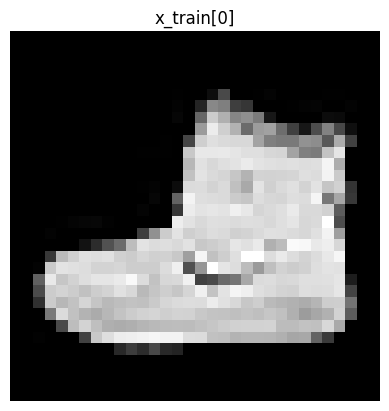

In [ ]:
import numpy as np

print("shape:", x_train.shape)
print("dtype:", x_train.dtype)

print("min, max, mean:", np.min(x_train), np.max(x_train), np.mean(x_train))
print("fraction zeros:", np.mean(x_train == 0.0))

flat = x_train.ravel()
print("unique sample values:", np.unique(flat[:1000])[:10])

import matplotlib.pyplot as plt
plt.imshow(x_train[0].squeeze(), cmap='gray')
plt.title("x_train[0]")
plt.axis('off')
plt.show()


### Model

In [8]:
# Encoder
encoder_input = layers.Input(shape=(32, 32, 1), name = "encoder_input")
x = layers.Conv2D(32, 3, strides = 2, activation = 'relu', padding = "same")(encoder_input)
x = layers.Conv2D(64, 3, strides = 2, activation = 'relu', padding = "same")(x)
x = layers.Conv2D(128, 3, strides = 2, activation = 'relu', padding = "same")(x)
shape_before_flattening = K.int_shape(x)[1:]
x = layers.Flatten()(x)
encoder_output = layers.Dense(2, name="encoder_output")(x)
encoder = models.Model(encoder_input, encoder_output)

In [9]:
# Decoder 
decoder_input = layers.Input(shape=(2, ), name = "decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, 3, strides = 2, activation = "relu", padding = "same")(x)
x = layers.Conv2DTranspose(64, 3, strides = 2, activation = "relu", padding = "same")(x)
x = layers.Conv2DTranspose(32, 3, strides = 2, activation = "relu", padding = "same")(x)
decoder_output = layers.Conv2D(1, 3, strides = 1, activation = "sigmoid", padding = "same", name = "decoder_output")(x)
decoder = models.Model(decoder_input, decoder_output)

In [10]:
# Autoencoder 
autoencoder = models.Model(encoder_input, decoder(encoder_output))
autoencoder.compile(optimizer = "adam", loss = "binary_crossentropy")

In [11]:
autoencoder.fit(
    x_train,
    x_train,
    epochs = 5,
    batch_size = 100, 
    shuffle = True,
    validation_data = (x_test, x_test)
)

Epoch 1/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 28s 41ms/step - loss: 0.3001 - val_loss: 0.2669
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 40s 66ms/step - loss: 0.2612 - val_loss: 0.2600
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 58s 97ms/step - loss: 0.2568 - val_loss: 0.2566
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 47s 78ms/step - loss: 0.2543 - val_loss: 0.2547
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 42s 70ms/step - loss: 0.2527 - val_loss: 0.2535


In [12]:
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 32, 32, 1)      │       246,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,029,131 (3.93 MB)

 Trainable params: 343,043 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 686,088 (2.62 MB)

### Testing

In [13]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

In [14]:
predictions = autoencoder.predict(example_images)

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


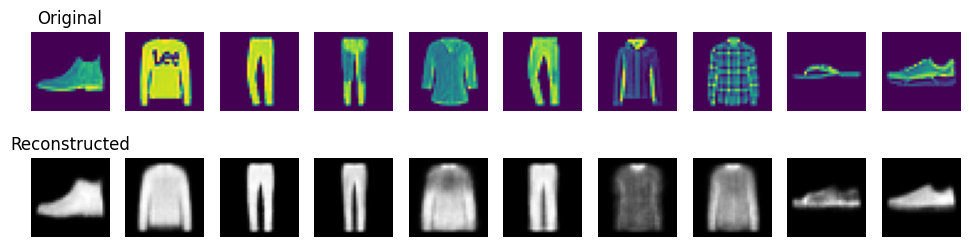

In [15]:
n = len(example_images)
plt.figure(figsize=(12, 3))

for i in range(10):
    # Original
    plt.subplot(2, 10, i+1)
    plt.imshow(example_images[i].squeeze())
    plt.axis('off')
    if i == 0:
        plt.title("Original")

    # Reconstruction
    plt.subplot(2, 10, 10+i+1)
    plt.imshow(predictions[i].squeeze(), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title("Reconstructed")

plt.show()


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


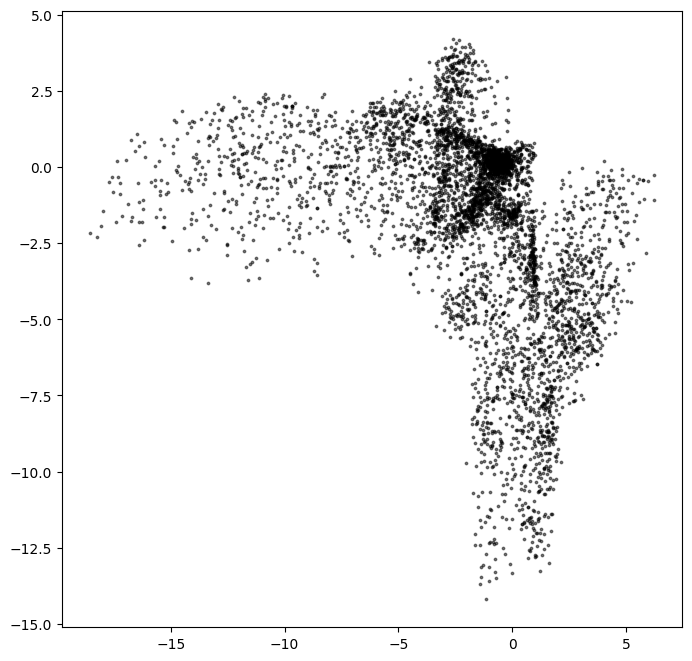

In [16]:
embeddings = encoder.predict(example_images) 
plt.figure(figsize=(8, 8)) 
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3) 
plt.show()

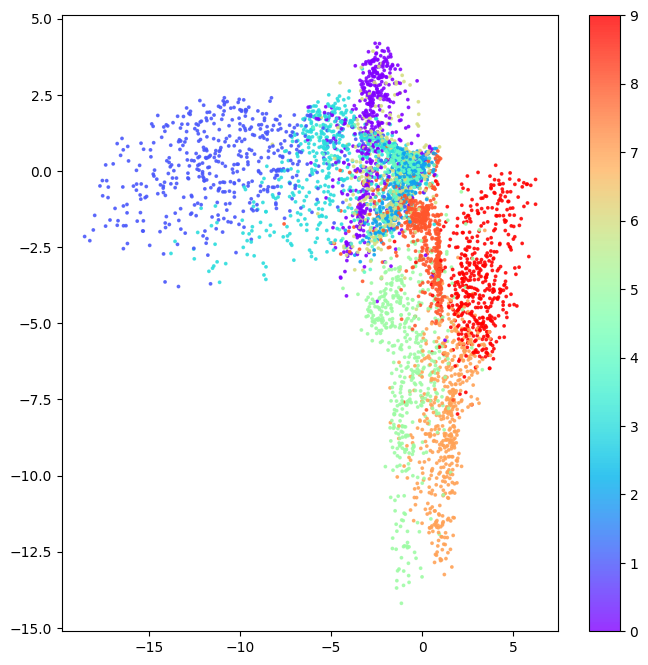

In [17]:
example_labels = y_test[:n_to_predict]

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

In [18]:
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 100
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 3

### Sample some points in the latent space

In [19]:

mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

grid_width, grid_height = (6, 3)
sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, EMBEDDING_DIM)
)

In [20]:
reconstructions = decoder.predict(sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


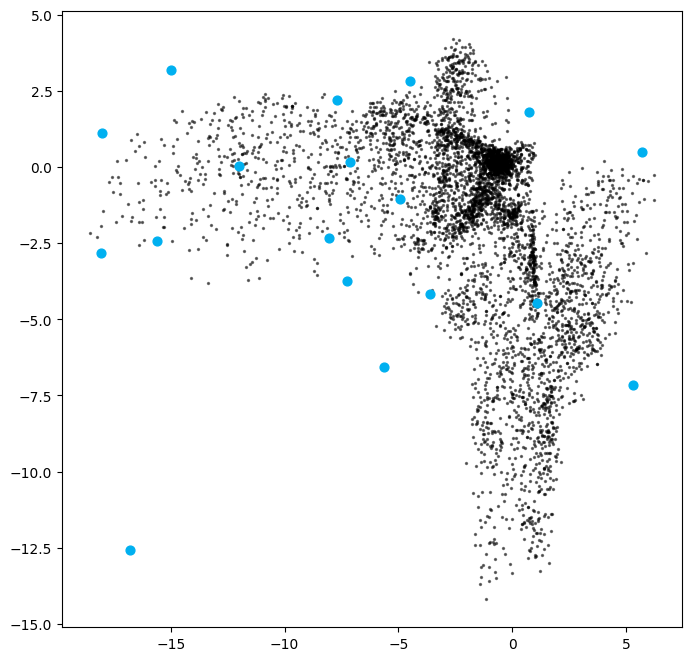

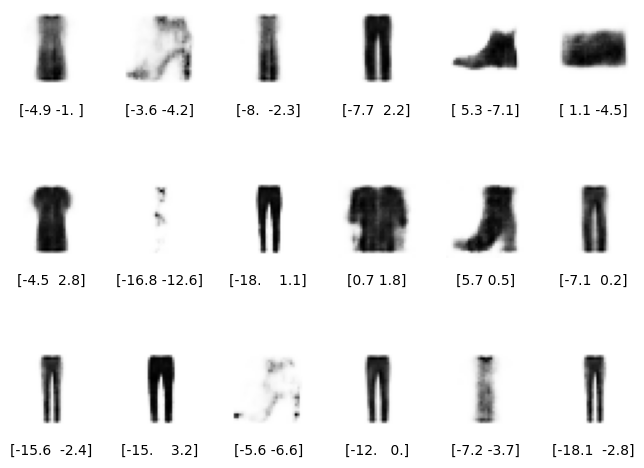

In [21]:
figsize = 8
plt.figure(figsize=(figsize, figsize))

# Original Embeddings
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# Newly generated points
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


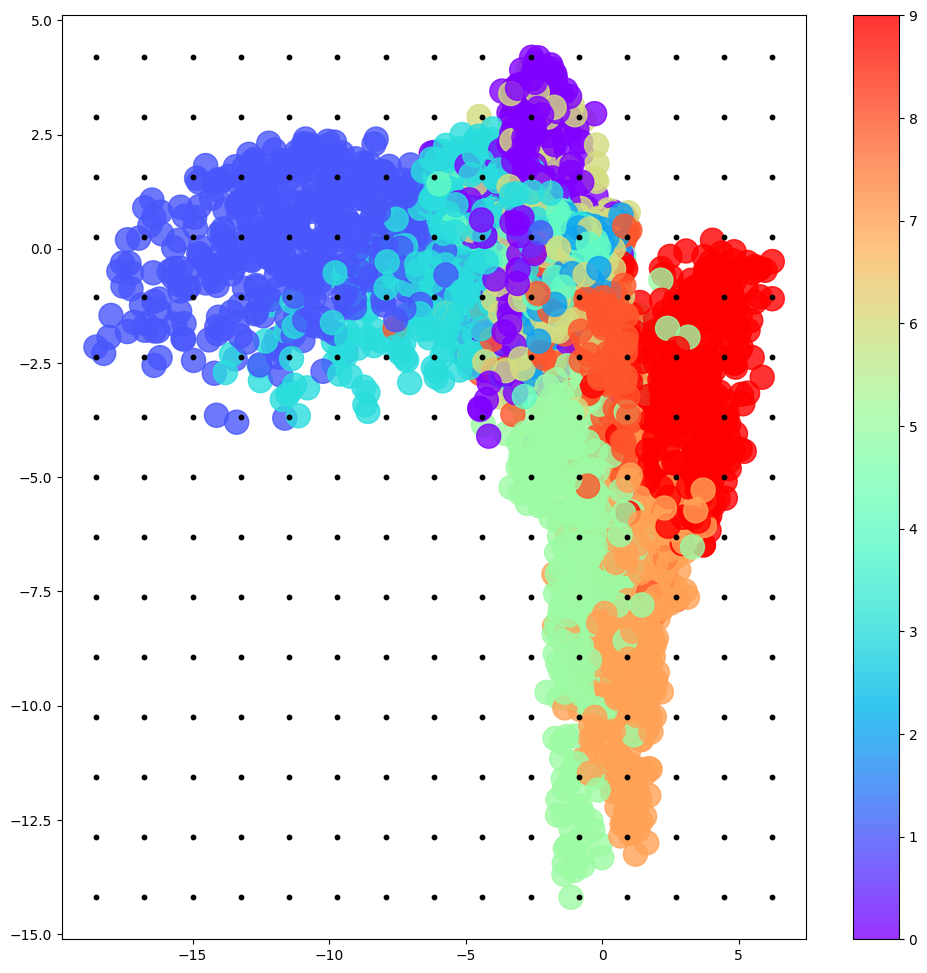

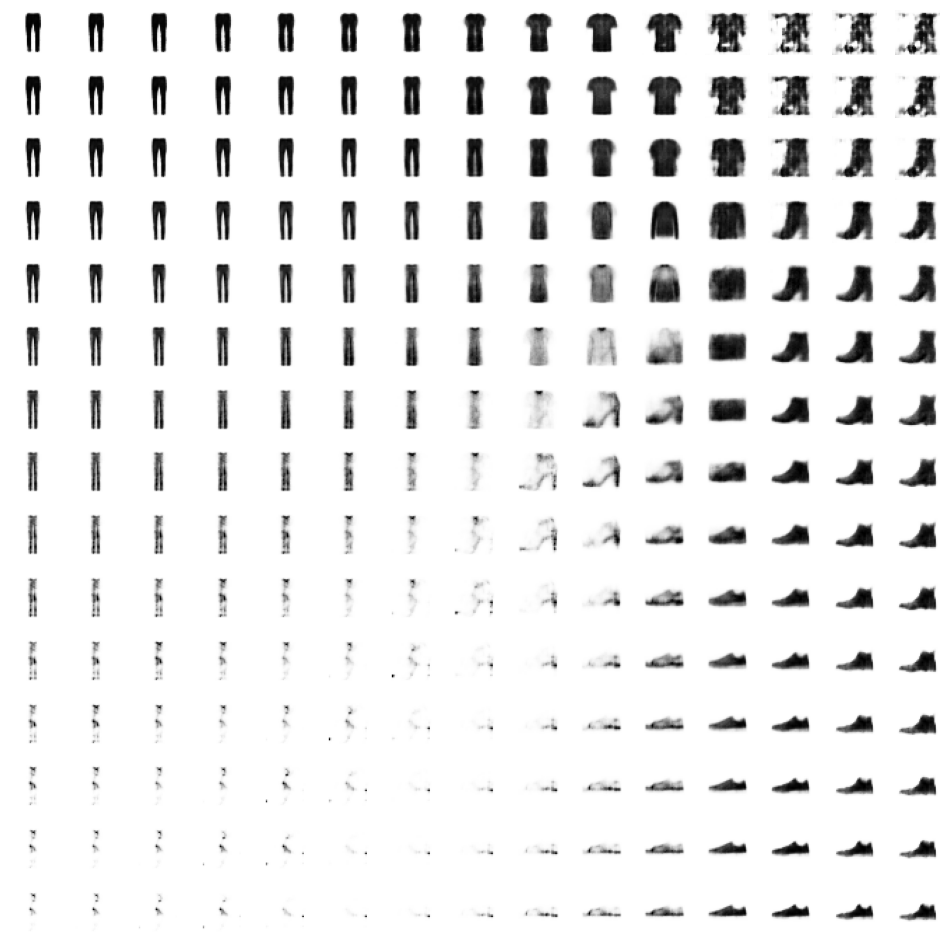

In [26]:
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=300,
)
plt.colorbar()

x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = np.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")